## 1. Imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. Data

In [4]:
from PIL import Image
import torchvision.transforms as transforms

imsize = 256
img_transforms = transforms.Compose([
    transforms.Resize((imsize, imsize)), 
    transforms.ToTensor()
])

In [5]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = img_transforms(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader("style_img.jpg")
content_img = image_loader("content_img.jpg")

output_img = content_img.clone().requires_grad_(True).to(device)
#output_img = torch.rand(content_img.shape).to(device)
#output_img = output_img.requires_grad_(True)

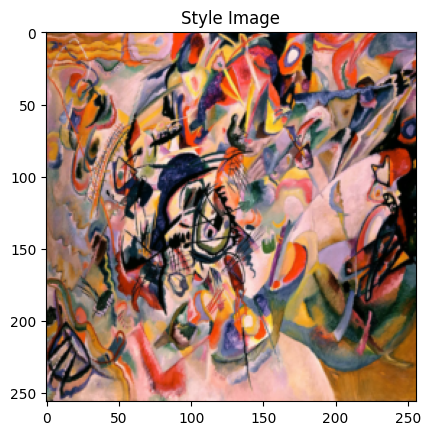

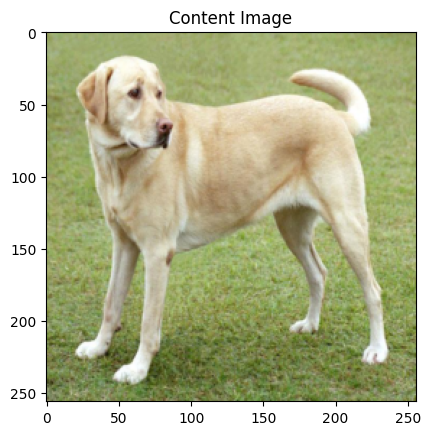

In [6]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone() 
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## 3. Loss Functions

### 3.1 Content Loss

In [7]:
content_weight = 1
ContentLoss = nn.MSELoss()

### 3.2 Style Loss

In [8]:
def gram_matrix(tensor):
    a, b, c, d = tensor.size()
    tensor = tensor.view(a * b, c * d)
    G = torch.mm(tensor, tensor.t())
    return G.div(a * b * c * d)

style_weight = 1e6
StyleLoss = nn.MSELoss()

## 3. Model

In [9]:
from torchvision.models import vgg19, VGG19_Weights

VGG19_pretrained = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()
for param in VGG19_pretrained.parameters():
    param.requires_grad_(False)

VGG19_pretrained = VGG19_pretrained[:11]
VGG19_pretrained.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

## 4. Training

In [10]:
import torch.optim as optim


optimizer = optim.Adam([output_img], lr=0.02)

In [11]:
STEPS = 2000

style_features = VGG19_pretrained(style_img)
style_gram = gram_matrix(style_features)

for step in range(STEPS):
    optimizer.zero_grad()    
    content_loss = ContentLoss(content_img, output_img)
    
    output_features = VGG19_pretrained(output_img)    
    output_gram = gram_matrix(output_features)    
    style_loss = StyleLoss(style_gram, output_gram)

    total_loss = content_loss*content_weight + style_loss*style_weight
    total_loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        output_img.clamp_(0, 1)
    
    if step % 100 == 0:
        print(f"Epoch [{step+1}/{STEPS}] total loss: {total_loss.item():.8f}")

Epoch [1/2000] total loss: 1502.75866699
Epoch [101/2000] total loss: 2.05932689
Epoch [201/2000] total loss: 0.70876551
Epoch [301/2000] total loss: 0.39368415
Epoch [401/2000] total loss: 0.26281366
Epoch [501/2000] total loss: 0.19564180
Epoch [601/2000] total loss: 0.39545628
Epoch [701/2000] total loss: 0.13145901
Epoch [801/2000] total loss: 0.23487410
Epoch [901/2000] total loss: 0.11430704
Epoch [1001/2000] total loss: 0.10610066
Epoch [1101/2000] total loss: 1.80129194
Epoch [1201/2000] total loss: 0.16695127
Epoch [1301/2000] total loss: 0.41306388
Epoch [1401/2000] total loss: 0.16009715
Epoch [1501/2000] total loss: 0.09936591
Epoch [1601/2000] total loss: 0.07618113
Epoch [1701/2000] total loss: 0.06830999
Epoch [1801/2000] total loss: 0.43094361
Epoch [1901/2000] total loss: 0.06917912


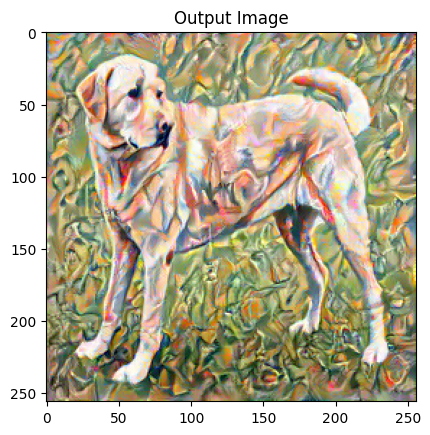

In [12]:
plt.figure()
imshow(output_img.detach(), title='Output Image')
plt.show()